In [1]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import math
import sys
import scipy.stats as stats
from collections import defaultdict

In [3]:
def loaddata(tickerlist, period='5y'):
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = tickerlist,

            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,

            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = "1d",

            # Whether to ignore timezone when aligning ticker data from 
            # different timezones. Default is False.
            ignore_tz = False, # !!

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = True,  

            # attempt repair of missing data or currency mixups e.g. $/cents
            repair = False,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = True,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    collist = []
    
    for i in data.columns:
        if i[1] == 'Close': #there were no adj close for most tickers
            collist.append(i)
    data = data[collist]
    
    tmp = []
    for i in data.columns:
        tmp.append(i[0])
    data.columns = tmp
    
    return data

In [4]:
def CleanData(data): #for cleaning data of 1 pair
    # 1) drop weekend
    for i in range(data.shape[0]):
        if pd.isna(data.iloc[i,0]) and pd.isna(data.iloc[i,1]):
            data = data.drop(data.index[i],axis=0)
    # 2) cal logreturn
        cleaned_data = 100*np.log(data/data.shift(1))
    # 3) dropna
        cleaned_data = cleaned_data.dropna(axis=0)
    return cleaned_data

In [5]:
pairs = [('^AORD', '^AXJO'), ('^BUK100P', '^FTSE'), ('000001.SS', '399001.SZ'), ('^TWII', '^KS11'), ('^N100', '^STOXX50E'), ('^N100', '^GDAXI'), ('^N100', '^FCHI'), ('^STOXX50E', '^GDAXI'), ('^STOXX50E', '^FCHI'), ('^GDAXI', '^FCHI'), ('^NYA', '^DJI'), ('^NYA', '^GSPC'), ('^NYA', '^IXIC'), ('^NYA', '^XAX'), ('^NYA', '^RUT'), ('^NYA', '^GSPTSE'), ('^DJI', '^GSPC'), ('^DJI', '^IXIC'), ('^DJI', '^XAX'), ('^DJI', '^RUT'), ('^DJI', '^GSPTSE'), ('^GSPC', '^IXIC'), ('^GSPC', '^XAX'), ('^GSPC', '^RUT'), ('^GSPC', '^GSPTSE'), ('^IXIC', '^XAX'), ('^IXIC', '^RUT'), ('^IXIC', '^GSPTSE'), ('^XAX', '^RUT'), ('^XAX', '^GSPTSE'), ('^RUT', '^GSPTSE')]

# Defining a dict
d = defaultdict(list)

for pair in pairs:
    data = loaddata(pair)
    data = CleanData(data)
    d[pair].append(np.array(data))

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

In [6]:
d.items()

dict_items([(('^AORD', '^AXJO'), [array([[-0.71230808, -0.68235497],
       [-0.74608239, -0.78156217],
       [ 0.51479031, -0.53223465],
       ...,
       [ 0.29604607,  0.26924276],
       [-1.13132679, -1.24697873],
       [ 0.46398805,  0.51621212]])]), (('^BUK100P', '^FTSE'), [array([], shape=(0, 2), dtype=float64)]), (('000001.SS', '399001.SZ'), [array([[ 0.43920371,  1.05090623],
       [-0.58903275, -0.79709318],
       [ 0.07365327,  0.17881311],
       ...,
       [-0.62002288, -0.81827621],
       [-0.27983519, -0.72799115],
       [ 0.66003296,  0.69700133]])]), (('^TWII', '^KS11'), [array([], shape=(0, 2), dtype=float64)]), (('^N100', '^STOXX50E'), [array([[-0.96737712, -1.16407723],
       [-2.00937127, -2.21338331],
       [ 0.80721103,  0.9152683 ],
       ...,
       [-1.589087  , -1.88083108],
       [ 1.39892228,  1.64217148],
       [-0.30441613, -0.09066257]])]), (('^N100', '^GDAXI'), [array([[-0.96737712, -1.98903108],
       [-2.00937127, -2.30032536],
       [

### Finding top5 pairs which have smallest distance

In [7]:
def smallest_avg_dist_pair(d):
    pairs = {}
    
    for key, value in d.items():
        if value[0].shape[0] == 0:
            pass
        else:
            dist = 0
            for i in range(value[0].shape[0]):
                dist += (value[0][i][0] - value[0][i][1])**2
            dist /= value[0].shape[0]
            pairs[key] = dist
    
    pairs = pairs.items()
    new_pairs = sorted(pairs, key=lambda ele:ele[1])
    
    return new_pairs

In [11]:
new_pairs = smallest_avg_dist_pair(d)
new_pairs

[(('^AORD', '^AXJO'), 0.00992448656831574),
 (('^N100', '^FCHI'), 0.05488883372165996),
 (('^N100', '^STOXX50E'), 0.06506259260432384),
 (('^STOXX50E', '^FCHI'), 0.0651851248612605),
 (('^STOXX50E', '^GDAXI'), 0.09111199181987542),
 (('^NYA', '^DJI'), 0.12193421594746406),
 (('^DJI', '^GSPC'), 0.13797468296992452),
 (('^NYA', '^GSPC'), 0.15185250284852225),
 (('^N100', '^GDAXI'), 0.2051032519767768),
 (('^GDAXI', '^FCHI'), 0.20603928547610958),
 (('^GSPC', '^IXIC'), 0.28991214136963045),
 (('000001.SS', '399001.SZ'), 0.3492739308638613),
 (('^NYA', '^GSPTSE'), 0.35040673642650383),
 (('^DJI', '^GSPTSE'), 0.5081036777050068),
 (('^GSPC', '^GSPTSE'), 0.5426893343092981),
 (('^NYA', '^RUT'), 0.5450346138243589),
 (('^GSPC', '^RUT'), 0.6315067204298079),
 (('^DJI', '^IXIC'), 0.718897979621935),
 (('^DJI', '^RUT'), 0.7232050978675647),
 (('^NYA', '^IXIC'), 0.7241425232877133),
 (('^IXIC', '^RUT'), 0.8328061667542555),
 (('^RUT', '^GSPTSE'), 0.9968015100291538),
 (('^XAX', '^GSPTSE'), 1.0675

### Kendall's Tau

In [12]:
import scipy.stats as stats
for i in range(0, 5):
    pair = new_pairs[i][0]
    tau, p_value = stats.kendalltau(d[pair][0][:, 0], d[pair][0][:, 1])
    print(pair, tau)
    print("%.3f" % p_value)

('^AORD', '^AXJO') 0.9397807232858779
0.000
('^N100', '^FCHI') 0.8650698252754466
0.000
('^N100', '^STOXX50E') 0.8604535985220707
0.000
('^STOXX50E', '^FCHI') 0.8461826710166006
0.000
('^STOXX50E', '^GDAXI') 0.8269433642029375
0.000


### References

https://towardsdatascience.com/every-statistical-test-to-check-feature-dependence-773a21cd6722

### Visualization

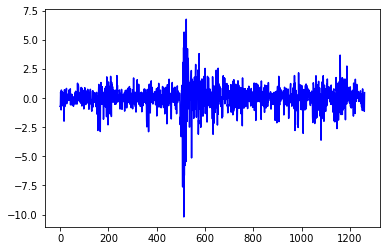

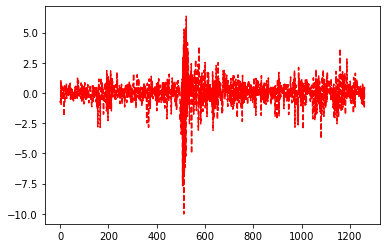

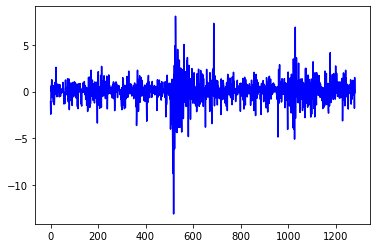

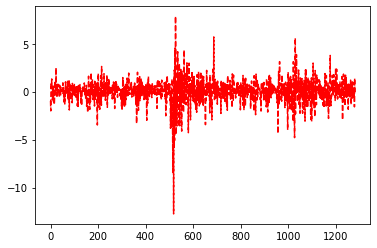

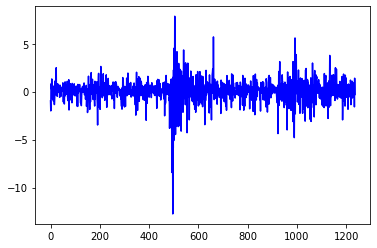

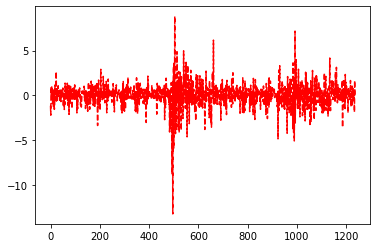

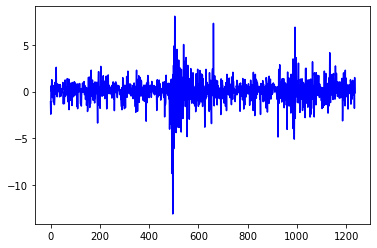

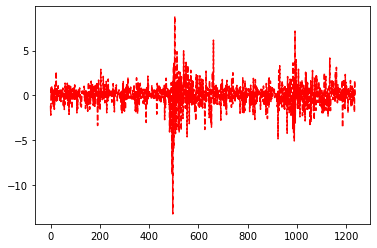

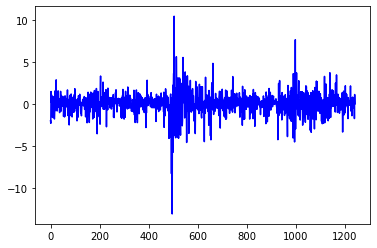

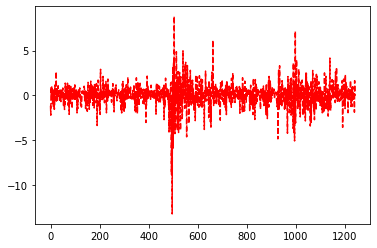

In [13]:
for i in range(0, 5):
    fig, ax = plt.subplots()
    pair = new_pairs[i][0]
    ax.plot(d[pair][0][:, 0], '-b')
    fig, ax = plt.subplots()
    ax.plot(d[pair][0][:, 1], '--r')